In [1]:
import pandas as pd
import seaborn as sns
import dexplot as dxp
import sklearn_pandas
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [3]:
df2 = pd.read_csv("train_transaction.csv")

In [4]:
df2.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
uid_df = pd.read_csv("train_uids_full_v3.csv")

In [6]:
df = pd.merge(df2,uid_df.iloc[:,1:],on='TransactionID')

In [7]:
df.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,uid
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987000.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987001.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987002.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2987003.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2987004.0


## delete NA columns

In [8]:
percent_missing = df.isnull().sum()*100/len(df)

In [9]:
missing_cols = list(percent_missing[percent_missing>30].index)

In [10]:
df = df.drop(columns=missing_cols)

In [11]:
cat_list = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6","addr1","addr2","P_emaildomain","M6"]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


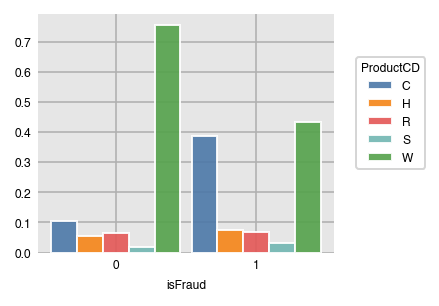

In [11]:

dxp.count('isFraud', data=df, split='ProductCD', normalize='isFraud')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


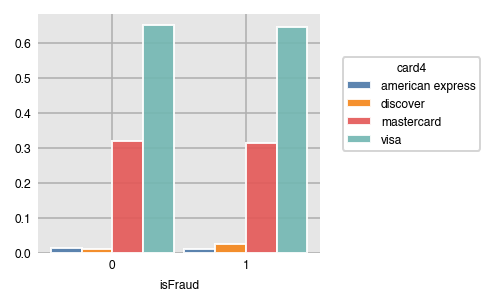

In [12]:
dxp.count('isFraud', data=df, split='card4', normalize='isFraud')

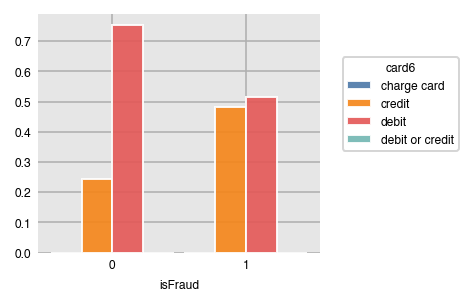

In [13]:
dxp.count('isFraud', data=df, split='card6', normalize='isFraud')

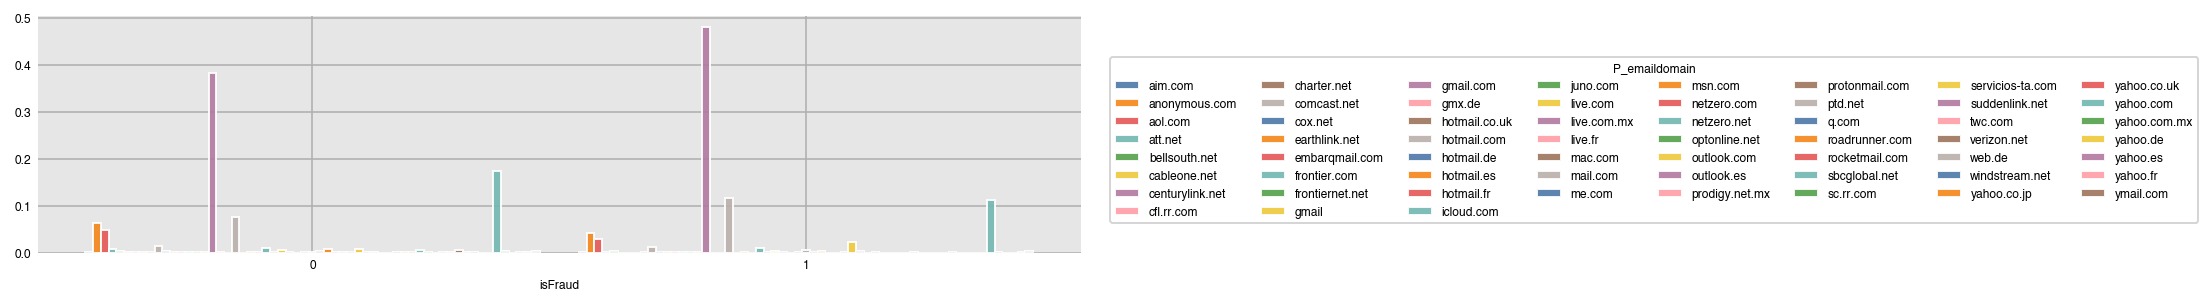

In [14]:

dxp.count('isFraud', data=df, split='P_emaildomain', normalize='isFraud')

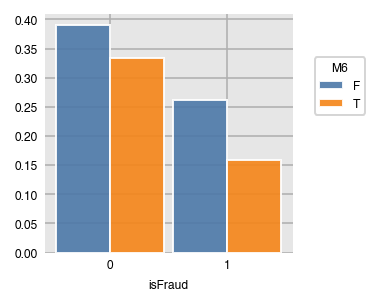

In [15]:
dxp.count('isFraud', data=df, split='M6', normalize='isFraud')

## fillna

In [12]:
df[cat_list] = df[cat_list].astype("object")

In [13]:

# handling NaN values
imputer = SimpleImputer(strategy="most_frequent")
df[cat_list] = imputer.fit_transform(df[cat_list])

In [14]:
imputer2 = SimpleImputer(strategy="median")
df_num = df.drop(cat_list, axis = 1)
df[df_num.columns]= imputer2.fit_transform(df[df_num.columns])

In [15]:
# need to remap, then do one-hot coding
map_list = ["P_emaildomain"]

# delete after agg, same as the cat_list
del_list = ["card1", "card2", "card3","card5","addr1","addr2", "card6", "M6", "ProductCD", "card4", "P_emaildomain"]

# directly use one-hot coding

one_hot = ["card6", "M6", "ProductCD", "card4", "P_emaildomain"]

## Feature Engineer

### change map_list

In [16]:
email_list = list(df["P_emaildomain"].unique())
email_list = email_list[1:]

In [17]:
[s for s in email_list if "gmail" in s] 

['gmail']

In [18]:
df.loc[df["P_emaildomain"].isin(['gmail']),"P_emaildomain"] = "gmail.com"

In [19]:
yahood = [s for s in email_list if "yahoo" in s] 
yahood

['yahoo.com',
 'yahoo.com.mx',
 'yahoo.fr',
 'yahoo.de',
 'yahoo.es',
 'yahoo.co.uk',
 'yahoo.co.jp']

In [20]:
df.loc[df["P_emaildomain"].isin(yahood),"P_emaildomain"] = "yahoo.com"

In [21]:
hm = [s for s in email_list if "hotmail" in s] 
hm

['hotmail.com', 'hotmail.es', 'hotmail.fr', 'hotmail.de', 'hotmail.co.uk']

In [22]:
df.loc[df["P_emaildomain"].isin(hm),"P_emaildomain"] = "hotmail.com"

In [23]:
df.loc[~df["P_emaildomain"].isin(['gmail.com',"yahoo.com","hotmail.com","anonymous.com","aol.com"]),"P_emaildomain"] = "Others" 

### one hot coding

In [24]:
one_hot

['card6', 'M6', 'ProductCD', 'card4', 'P_emaildomain']

In [25]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
one_code_df = pd.DataFrame(encoder.fit_transform(df[one_hot]).toarray())
one_code_df.columns = encoder.get_feature_names(one_hot)
one_code_df

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,card6_charge card,card6_credit,card6_debit,card6_debit or credit,M6_F,M6_T,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,...,card4_american express,card4_discover,card4_mastercard,card4_visa,P_emaildomain_Others,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_gmail.com,P_emaildomain_hotmail.com,P_emaildomain_yahoo.com
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
590501,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
590502,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
590503,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [26]:
df3 = df.join(one_code_df)

In [27]:
df3

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card4_american express,card4_discover,card4_mastercard,card4_visa,P_emaildomain_Others,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_gmail.com,P_emaildomain_hotmail.com,P_emaildomain_yahoo.com
0,2987000.0,0.0,86400.0,68.50,W,13926,321.0,150.0,discover,142.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2987001.0,0.0,86401.0,29.00,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2987002.0,0.0,86469.0,59.00,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2987003.0,0.0,86499.0,50.00,W,18132,567.0,150.0,mastercard,117.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2987004.0,0.0,86506.0,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590500,3577535.0,0.0,15811047.0,49.00,W,6550,321.0,150.0,visa,226.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
590501,3577536.0,0.0,15811049.0,39.50,W,10444,225.0,150.0,mastercard,224.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
590502,3577537.0,0.0,15811079.0,30.95,W,12037,595.0,150.0,mastercard,224.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
590503,3577538.0,0.0,15811088.0,117.00,W,7826,481.0,150.0,mastercard,224.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## aggregation

In [28]:
num_list= list(df3.columns[(~df3.columns.isin(cat_list)) & (~df3.columns.isin(list(one_code_df.columns)))])
del num_list[0:2]
del num_list[189]

In [29]:
num_agg = df3.groupby(['uid'])[num_list].agg(['mean', 'std'])

In [30]:
num_agg_col = list()
for i in num_list:
    num_agg_col.append(i+"_mean")
    num_agg_col.append(i+"_std")

In [31]:
num_agg.columns = num_agg_col

In [32]:
num_agg.reset_index(inplace = True)

In [33]:
num_agg

,uid,TransactionDT_mean,TransactionDT_std,TransactionAmt_mean,TransactionAmt_std,C1_mean,C1_std,C2_mean,C2_std,C3_mean,...,V317_mean,V317_std,V318_mean,V318_std,V319_mean,V319_std,V320_mean,V320_std,V321_mean,V321_std
0,2987000.0,8.640000e+04,NaN,68.500000,NaN,1.0,NaN,1.0,NaN,0.0,...,117.000000,NaN,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN
1,2987001.0,8.640100e+04,NaN,29.000000,NaN,1.0,NaN,1.0,NaN,0.0,...,0.000000,NaN,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN
2,2987002.0,8.565982e+06,6.189580e+06,73.500000,17.058722,1.0,0.0,1.5,0.57735,0.0,...,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2987003.0,2.829580e+06,1.749519e+06,66.392857,24.985305,2.0,0.0,5.0,0.00000,0.0,...,1494.154762,686.25631,633.666667,530.80349,2.72619,15.067999,147.666667,141.711597,10.071429,32.967595
4,2987004.0,8.650600e+04,NaN,50.000000,NaN,1.0,NaN,1.0,NaN,0.0,...,0.000000,NaN,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312782,3577530.0,1.581093e+07,NaN,400.780000,NaN,1.0,NaN,1.0,NaN,0.0,...,0.000000,NaN,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN
312783,3577532.0,1.581101e+07,NaN,204.970000,NaN,1.0,NaN,1.0,NaN,0.0,...,0.000000,NaN,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN
312784,3577534.0,1.581103e+07,NaN,67.505000,NaN,1.0,NaN,1.0,NaN,0.0,...,0.000000,NaN,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN
312785,3577536.0,1.581105e+07,NaN,39.500000,NaN,1.0,NaN,1.0,NaN,0.0,...,0.000000,NaN,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN


In [34]:
cat_agg = df3.groupby(['uid'])[cat_list].nunique()

In [35]:
cat_agg_col = list()
for i in cat_list:
    cat_agg_col.append(i+"_nunique")
cat_agg_col

['ProductCD_nunique',
 'card1_nunique',
 'card2_nunique',
 'card3_nunique',
 'card4_nunique',
 'card5_nunique',
 'card6_nunique',
 'addr1_nunique',
 'addr2_nunique',
 'P_emaildomain_nunique',
 'M6_nunique']

In [38]:
cat_agg.columns = cat_agg_col
cat_agg.reset_index(inplace=True)
cat_agg

,uid,ProductCD_nunique,card1_nunique,card2_nunique,card3_nunique,card4_nunique,card5_nunique,card6_nunique,addr1_nunique,addr2_nunique,P_emaildomain_nunique,M6_nunique
0,2987000.0,1,1,1,1,1,1,1,1,1,1,1
1,2987001.0,1,1,1,1,1,1,1,1,1,1,1
2,2987002.0,1,1,1,1,1,1,1,1,1,1,1
3,2987003.0,1,1,1,1,1,1,1,1,1,1,1
4,2987004.0,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
312782,3577530.0,1,1,1,1,1,1,1,1,1,1,1
312783,3577532.0,1,1,1,1,1,1,1,1,1,1,1
312784,3577534.0,1,1,1,1,1,1,1,1,1,1,1
312785,3577536.0,1,1,1,1,1,1,1,1,1,1,1


In [39]:
df4 = pd.merge(pd.merge(df3,cat_agg,on='uid'), num_agg, on = 'uid')

In [40]:
df4 = df4.drop(cat_list, axis = 1).fillna(0)

## normalization

In [41]:
from sklearn.preprocessing import normalize

norm_col = list(df4.columns[(~df4.columns.isin(["uid", "isFraud", "TransactionID"])) & (~df4.columns.isin(list(one_code_df.columns)))])

normalized_arr = normalize(df4[norm_col])

In [42]:

scaled_df = pd.DataFrame(normalized_arr, columns=norm_col)

In [43]:

predictors_scaled_df = pd.concat([scaled_df, one_code_df], axis=1)

In [44]:
X = predictors_scaled_df
y = df4['isFraud'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [45]:
X_sub = X_train.iloc[:2000,:]
y_sub = y_train[:2000]

### KNN

In [81]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose = 2)
#fit model to data
knn_gscv.fit(X_sub, y_sub)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] END ......................................n_neighbors=1; total time=   0.2s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=2; total time=   0.1s
[CV] END ......................................n_neighbors=2; total time=   0.1s
[CV] END ......................................n_neighbors=2; total time=   0.1s
[CV] END ......................................n_neighbors=2; total time=   0.1s
[CV] END ......................................n_neighbors=2; total time=   0.1s
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................

[CV] END .....................................n_neighbors=21; total time=   0.1s
[CV] END .....................................n_neighbors=21; total time=   0.1s
[CV] END .....................................n_neighbors=21; total time=   0.1s
[CV] END .....................................n_neighbors=22; total time=   0.1s
[CV] END .....................................n_neighbors=22; total time=   0.1s
[CV] END .....................................n_neighbors=22; total time=   0.1s
[CV] END .....................................n_neighbors=22; total time=   0.1s
[CV] END .....................................n_neighbors=22; total time=   0.1s
[CV] END .....................................n_neighbors=23; total time=   0.1s
[CV] END .....................................n_neighbors=23; total time=   0.1s
[CV] END .....................................n_neighbors=23; total time=   0.1s
[CV] END .....................................n_neighbors=23; total time=   0.1s
[CV] END ...................

[CV] END .....................................n_neighbors=41; total time=   0.1s
[CV] END .....................................n_neighbors=42; total time=   0.1s
[CV] END .....................................n_neighbors=42; total time=   0.1s
[CV] END .....................................n_neighbors=42; total time=   0.1s
[CV] END .....................................n_neighbors=42; total time=   0.1s
[CV] END .....................................n_neighbors=42; total time=   0.1s
[CV] END .....................................n_neighbors=43; total time=   0.1s
[CV] END .....................................n_neighbors=43; total time=   0.1s
[CV] END .....................................n_neighbors=43; total time=   0.1s
[CV] END .....................................n_neighbors=43; total time=   0.1s
[CV] END .....................................n_neighbors=43; total time=   0.1s
[CV] END .....................................n_neighbors=44; total time=   0.1s
[CV] END ...................

[CV] END .....................................n_neighbors=62; total time=   0.1s
[CV] END .....................................n_neighbors=62; total time=   0.1s
[CV] END .....................................n_neighbors=62; total time=   0.1s
[CV] END .....................................n_neighbors=62; total time=   0.1s
[CV] END .....................................n_neighbors=63; total time=   0.1s
[CV] END .....................................n_neighbors=63; total time=   0.1s
[CV] END .....................................n_neighbors=63; total time=   0.1s
[CV] END .....................................n_neighbors=63; total time=   0.1s
[CV] END .....................................n_neighbors=63; total time=   0.1s
[CV] END .....................................n_neighbors=64; total time=   0.1s
[CV] END .....................................n_neighbors=64; total time=   0.1s
[CV] END .....................................n_neighbors=64; total time=   0.1s
[CV] END ...................

[CV] END .....................................n_neighbors=82; total time=   0.1s
[CV] END .....................................n_neighbors=82; total time=   0.1s
[CV] END .....................................n_neighbors=83; total time=   0.1s
[CV] END .....................................n_neighbors=83; total time=   0.1s
[CV] END .....................................n_neighbors=83; total time=   0.1s
[CV] END .....................................n_neighbors=83; total time=   0.1s
[CV] END .....................................n_neighbors=83; total time=   0.1s
[CV] END .....................................n_neighbors=84; total time=   0.1s
[CV] END .....................................n_neighbors=84; total time=   0.1s
[CV] END .....................................n_neighbors=84; total time=   0.1s
[CV] END .....................................n_neighbors=84; total time=   0.1s
[CV] END .....................................n_neighbors=84; total time=   0.1s
[CV] END ...................

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             verbose=2)

In [82]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 9}

In [80]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.9279999999999999

In [84]:
knn2 = KNeighborsClassifier(n_neighbors = 9)
# Fit the classifier to the data
knn2.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=9)

In [86]:
y_pred = knn2.predict(X_test)

In [91]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[170823,    130],
       [  5973,    226]])

In [94]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.03645749314405549

In [97]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average=None)

(array([0.9662153 , 0.63483146]),
 array([0.99923956, 0.03645749]),
 array([0.98244999, 0.068955  ]),
 array([170953,   6199]))

In [ ]:
print metrics.accuracy_score(iris['target'], predicted)



print metrics.classification_report(iris['target'], predicted)

### Random Forest

In [102]:
X_train.shape

(3500, 599)

In [111]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier() #Initialize with whatever parameters you want to

param_grid = {
                 'n_estimators': np.arange(90,100,1),
                 'max_depth': np.arange(30,40,1)
             }
grid_clf = GridSearchCV(clf, param_grid, cv=5, verbose = 2)
grid_clf.fit(X_sub, y_sub)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ......................max_depth=30, n_estimators=90; total time=   1.0s
[CV] END ......................max_depth=30, n_estimators=90; total time=   0.8s
[CV] END ......................max_depth=30, n_estimators=90; total time=   0.9s
[CV] END ......................max_depth=30, n_estimators=90; total time=   0.9s
[CV] END ......................max_depth=30, n_estimators=90; total time=   0.9s
[CV] END ......................max_depth=30, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=30, n_estimators=91; total time=   0.8s
[CV] END ......................max_depth=30, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=30, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=30, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=30, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=30, n

[CV] END ......................max_depth=32, n_estimators=90; total time=   0.8s
[CV] END ......................max_depth=32, n_estimators=90; total time=   0.9s
[CV] END ......................max_depth=32, n_estimators=90; total time=   0.9s
[CV] END ......................max_depth=32, n_estimators=90; total time=   1.1s
[CV] END ......................max_depth=32, n_estimators=91; total time=   1.1s
[CV] END ......................max_depth=32, n_estimators=91; total time=   0.8s
[CV] END ......................max_depth=32, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=32, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=32, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=32, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=32, n_estimators=92; total time=   0.8s
[CV] END ......................max_depth=32, n_estimators=92; total time=   0.9s
[CV] END ...................

[CV] END ......................max_depth=34, n_estimators=90; total time=   0.9s
[CV] END ......................max_depth=34, n_estimators=90; total time=   1.0s
[CV] END ......................max_depth=34, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=34, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=34, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=34, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=34, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=34, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=34, n_estimators=92; total time=   0.8s
[CV] END ......................max_depth=34, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=34, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=34, n_estimators=92; total time=   0.9s
[CV] END ...................

[CV] END ......................max_depth=36, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=36, n_estimators=91; total time=   0.8s
[CV] END ......................max_depth=36, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=36, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=36, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=36, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=36, n_estimators=92; total time=   0.8s
[CV] END ......................max_depth=36, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=36, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=36, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=36, n_estimators=93; total time=   0.9s
[CV] END ......................max_depth=36, n_estimators=93; total time=   0.8s
[CV] END ...................

[CV] END ......................max_depth=38, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=38, n_estimators=91; total time=   0.9s
[CV] END ......................max_depth=38, n_estimators=91; total time=   0.8s
[CV] END ......................max_depth=38, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=38, n_estimators=92; total time=   1.0s
[CV] END ......................max_depth=38, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=38, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=38, n_estimators=92; total time=   0.9s
[CV] END ......................max_depth=38, n_estimators=93; total time=   0.9s
[CV] END ......................max_depth=38, n_estimators=93; total time=   0.8s
[CV] END ......................max_depth=38, n_estimators=93; total time=   0.9s
[CV] END ......................max_depth=38, n_estimators=93; total time=   1.1s
[CV] END ...................

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
                         'n_estimators': array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             verbose=2)

In [112]:
grid_clf. best_params_

{'max_depth': 31, 'n_estimators': 96}

In [113]:
rf2 = RandomForestClassifier(max_depth= 31, n_estimators = 96)
# Fit the classifier to the data
rf2.fit(X_train,y_train)

RandomForestClassifier(max_depth=31, n_estimators=96)

In [114]:
y_pred_rf1 = rf2.predict(X_test)

In [119]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(accuracy_score(y_test, y_pred_rf1))



print(classification_report(y_test, y_pred_rf1))

0.972283688583815
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    170953
         1.0       0.98      0.21      0.35      6199

    accuracy                           0.97    177152
   macro avg       0.98      0.61      0.67    177152
weighted avg       0.97      0.97      0.96    177152



In [120]:
confusion_matrix(y_test, y_pred_rf1)

array([[170929,     24],
       [  4886,   1313]])

### SMOTETomek

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state = 42)
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [47]:
X_smt = pd.read_csv("X_smt.csv", index_col=0)
X_smt

,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,...,card4_american express,card4_discover,card4_mastercard,card4_visa,P_emaildomain_Others,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_gmail.com,P_emaildomain_hotmail.com,P_emaildomain_yahoo.com
0,0.584414,0.000009,1.590974e-07,7.954869e-08,0.0,0.000000e+00,0.000000e+00,7.954869e-08,0.000000e+00,0.000000e+00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.698355,0.000005,2.622711e-07,1.967033e-07,0.0,0.000000e+00,0.000000e+00,1.967033e-07,0.000000e+00,0.000000e+00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.690983,0.000009,1.857232e-06,1.172989e-06,0.0,0.000000e+00,9.774905e-08,7.819924e-07,0.000000e+00,0.000000e+00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.707107,0.000004,8.818620e-08,8.818620e-08,0.0,8.818620e-08,0.000000e+00,8.818620e-08,0.000000e+00,8.818620e-08,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.707107,0.000387,3.427814e-06,3.427814e-06,0.0,0.000000e+00,0.000000e+00,1.713907e-06,0.000000e+00,0.000000e+00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764135,0.707107,0.000006,2.653398e-07,2.653398e-07,0.0,9.107936e-08,0.000000e+00,9.107936e-08,9.107936e-08,9.107936e-08,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
764136,0.707107,0.000003,2.593435e-07,6.287465e-07,0.0,1.100596e-07,0.000000e+00,1.100596e-07,1.100596e-07,1.100596e-07,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
764137,0.337843,0.000006,9.785863e-08,9.785863e-08,0.0,0.000000e+00,0.000000e+00,7.045041e-08,0.000000e+00,0.000000e+00,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
764138,0.707107,0.000003,5.745878e-07,8.266428e-07,0.0,1.712997e-07,0.000000e+00,1.712997e-07,1.712997e-07,6.249988e-07,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [48]:
y_smt = pd.read_csv("y_smt.csv", index_col=0)

,0
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
764135,1.0
764136,1.0
764137,1.0
764138,1.0


In [63]:

unique, counts = np.unique(y_smt, return_counts=True)

print (np.asarray((unique, counts)).T)

[[0.0000e+00 3.8207e+05]
 [1.0000e+00 3.8207e+05]]


In [53]:
y_smt = y_smt['0']

In [56]:
y_smt = y_smt.to_numpy()

In [57]:
pca = PCA(n_components = 0.95).fit(X_smt)

In [58]:
pca.n_components_

11

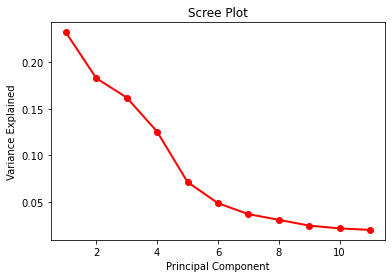

In [59]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

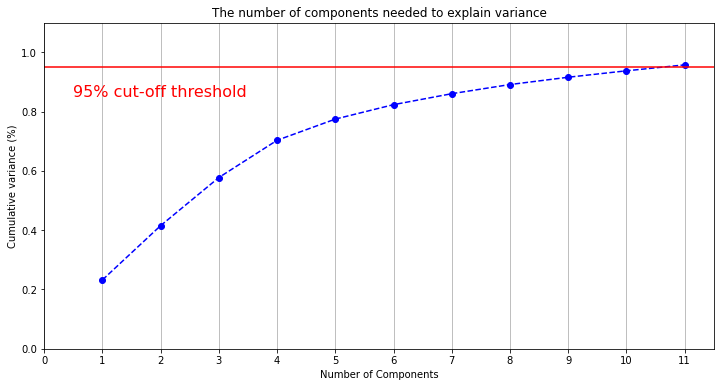

In [60]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 12, step=1)
yp = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yp, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 12, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [64]:
X_smt_pc = pca.transform(X_smt)
X_test_smt_pc = pca.transform(X_test)

In [66]:
pca_col =list()

for i in np.arange(1,12,1):
    pca_col.append("PC_{}".format(i))

In [67]:
X_smt_pc = pd.DataFrame(X_smt_pc, columns =pca_col )
X_test_smt_pc = pd.DataFrame(X_test_smt_pc, columns =pca_col)

In [72]:
import random

sub_index = random.sample(range(1, len(X_smt_pc)), 2000)

In [76]:
X_smt_sub = X_smt_pc.iloc[sub_index,:]
y_smt_sub = y_smt[sub_index]

**KNN**

In [78]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose = 2)
#fit model to data
knn_gscv.fit(X_smt_sub, y_smt_sub)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] END ......................................n_neighbors=1; total time=   0.1s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................

[CV] END .....................................n_neighbors=22; total time=   0.0s
[CV] END .....................................n_neighbors=22; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END ...................

[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END ...................

[CV] END .....................................n_neighbors=66; total time=   0.0s
[CV] END .....................................n_neighbors=66; total time=   0.0s
[CV] END .....................................n_neighbors=66; total time=   0.0s
[CV] END .....................................n_neighbors=66; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=68; total time=   0.0s
[CV] END .....................................n_neighbors=68; total time=   0.0s
[CV] END .....................................n_neighbors=68; total time=   0.0s
[CV] END ...................

[CV] END .....................................n_neighbors=87; total time=   0.0s
[CV] END .....................................n_neighbors=87; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=89; total time=   0.0s
[CV] END .....................................n_neighbors=89; total time=   0.0s
[CV] END .....................................n_neighbors=89; total time=   0.0s
[CV] END .....................................n_neighbors=89; total time=   0.0s
[CV] END .....................................n_neighbors=89; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             verbose=2)

In [79]:
knn_gscv.best_params_

{'n_neighbors': 5}

In [80]:
knn3 = KNeighborsClassifier(n_neighbors = 5)
# Fit the classifier to the data
knn3.fit(X_smt_pc,y_smt)

KNeighborsClassifier()

In [81]:
y_pred_k_2 = knn3.predict(X_test_smt_pc)

In [83]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_k_2)

array([[125892,  45061],
       [  3278,   2921]])

In [84]:
print(accuracy_score(y_test, y_pred_k_2))

print(classification_report(y_test, y_pred_k_2))

0.7271326318641619
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84    170953
         1.0       0.06      0.47      0.11      6199

    accuracy                           0.73    177152
   macro avg       0.52      0.60      0.47    177152
weighted avg       0.94      0.73      0.81    177152



**Random Forest**

In [88]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier() #Initialize with whatever parameters you want to

param_grid = {
                 'n_estimators': np.arange(1,12,1),
                 'max_depth': np.arange(5,40,5)
             }
grid_clf = GridSearchCV(clf, param_grid, cv=5, verbose = 2)
grid_clf.fit(X_smt_pc,y_smt)

Fitting 5 folds for each of 77 candidates, totalling 385 fits
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.7s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.6s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.6s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.5s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.5s
[CV] END ........................max_depth=5, n_estimators=2; total time=   1.0s
[CV] END ........................max_depth=5, n_estimators=2; total time=   1.0s
[CV] END ........................max_depth=5, n_estimators=2; total time=   1.0s
[CV] END ........................max_depth=5, n_estimators=2; total time=   0.9s
[CV] END ........................max_depth=5, n_estimators=2; total time=   1.0s
[CV] END ........................max_depth=5, n_estimators=3; total time=   1.4s
[CV] END ........................max_depth=5, n

[CV] END ......................max_depth=10, n_estimators=10; total time=   8.2s
[CV] END ......................max_depth=10, n_estimators=10; total time=   8.1s
[CV] END ......................max_depth=10, n_estimators=10; total time=   8.0s
[CV] END ......................max_depth=10, n_estimators=10; total time=   8.1s
[CV] END ......................max_depth=10, n_estimators=11; total time=   9.2s
[CV] END ......................max_depth=10, n_estimators=11; total time=   9.0s
[CV] END ......................max_depth=10, n_estimators=11; total time=   9.0s
[CV] END ......................max_depth=10, n_estimators=11; total time=   8.9s
[CV] END ......................max_depth=10, n_estimators=11; total time=   9.6s
[CV] END .......................max_depth=15, n_estimators=1; total time=   1.3s
[CV] END .......................max_depth=15, n_estimators=1; total time=   1.2s
[CV] END .......................max_depth=15, n_estimators=1; total time=   1.1s
[CV] END ...................

[CV] END .......................max_depth=20, n_estimators=8; total time=   9.6s
[CV] END .......................max_depth=20, n_estimators=8; total time=   9.7s
[CV] END .......................max_depth=20, n_estimators=9; total time=  11.2s
[CV] END .......................max_depth=20, n_estimators=9; total time=  10.9s
[CV] END .......................max_depth=20, n_estimators=9; total time=  10.5s
[CV] END .......................max_depth=20, n_estimators=9; total time=  10.7s
[CV] END .......................max_depth=20, n_estimators=9; total time=  11.0s
[CV] END ......................max_depth=20, n_estimators=10; total time=  12.2s
[CV] END ......................max_depth=20, n_estimators=10; total time=  12.1s
[CV] END ......................max_depth=20, n_estimators=10; total time=  12.2s
[CV] END ......................max_depth=20, n_estimators=10; total time=  12.2s
[CV] END ......................max_depth=20, n_estimators=10; total time=  12.2s
[CV] END ...................

[CV] END .......................max_depth=30, n_estimators=7; total time=   9.7s
[CV] END .......................max_depth=30, n_estimators=7; total time=   9.2s
[CV] END .......................max_depth=30, n_estimators=7; total time=   9.8s
[CV] END .......................max_depth=30, n_estimators=7; total time=   9.5s
[CV] END .......................max_depth=30, n_estimators=7; total time=   9.5s
[CV] END .......................max_depth=30, n_estimators=8; total time=  11.0s
[CV] END .......................max_depth=30, n_estimators=8; total time=  11.1s
[CV] END .......................max_depth=30, n_estimators=8; total time=  10.7s
[CV] END .......................max_depth=30, n_estimators=8; total time=  10.7s
[CV] END .......................max_depth=30, n_estimators=8; total time=  11.4s
[CV] END .......................max_depth=30, n_estimators=9; total time=  12.2s
[CV] END .......................max_depth=30, n_estimators=9; total time=  12.8s
[CV] END ...................

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25, 30, 35]),
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
             verbose=2)

In [89]:
grid_clf. best_params_

{'max_depth': 35, 'n_estimators': 11}

In [90]:
rf3 = RandomForestClassifier(max_depth= 35, n_estimators = 11)
# Fit the classifier to the data
rf3.fit(X_smt_pc,y_smt)

RandomForestClassifier(max_depth=35, n_estimators=11)

In [91]:

y_pred_rf2 = rf3.predict(X_test_smt_pc)
confusion_matrix(y_test, y_pred_rf2)


array([[86527, 84426],
       [ 2343,  3856]])

In [92]:
print(accuracy_score(y_test, y_pred_rf2))



print(classification_report(y_test, y_pred_rf2))

0.5102002799855492
              precision    recall  f1-score   support

         0.0       0.97      0.51      0.67    170953
         1.0       0.04      0.62      0.08      6199

    accuracy                           0.51    177152
   macro avg       0.51      0.56      0.37    177152
weighted avg       0.94      0.51      0.65    177152



In [93]:
rf2 = RandomForestClassifier(max_depth= 31, n_estimators = 96)
# Fit the classifier to the data
rf2.fit(X_smt,y_smt)

RandomForestClassifier(max_depth=31, n_estimators=96)

In [95]:
y_pred_rf4 = rf2.predict(X_test)
confusion_matrix(y_test, y_pred_rf4)

array([[99869, 71084],
       [ 1396,  4803]])

In [96]:
print(accuracy_score(y_test, y_pred_rf4))



print(classification_report(y_test, y_pred_rf4))

0.5908598265895953
              precision    recall  f1-score   support

         0.0       0.99      0.58      0.73    170953
         1.0       0.06      0.77      0.12      6199

    accuracy                           0.59    177152
   macro avg       0.52      0.68      0.43    177152
weighted avg       0.95      0.59      0.71    177152



## Random Over Sampling

In [97]:
X_ros = pd.read_csv("X_ros.csv", index_col=0)



In [106]:
y_ros = pd.read_csv("y_ros.csv", index_col=0)
y_ros = y_ros['0']
y_ros = y_ros.to_numpy()

In [98]:
pca = PCA(n_components = 0.95).fit(X_ros)

In [99]:
pca.n_components_

11

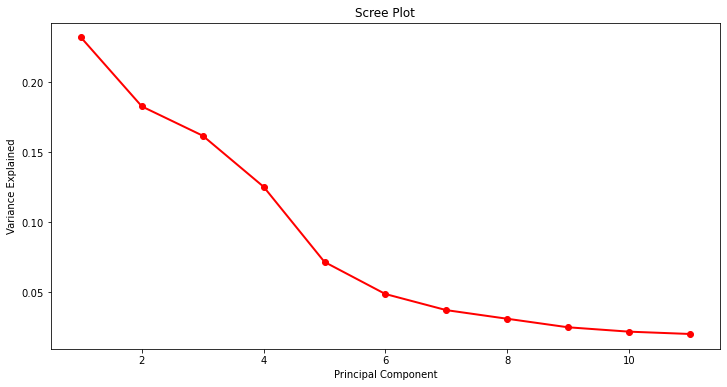

In [100]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [101]:
X_ros_pc = pca.transform(X_ros)
X_test_ros_pc = pca.transform(X_test)

In [102]:
X_ros_pc = pd.DataFrame(X_ros_pc, columns =pca_col )
X_test_ros_pc = pd.DataFrame(X_test_ros_pc, columns =pca_col)

In [112]:
X_ros_sub = X_ros_pc.iloc[sub_index,:]
y_ros_sub = y_ros[sub_index]

In [114]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose = 2)
#fit model to data
knn_gscv.fit(X_ros_sub, y_ros_sub)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................

[CV] END .....................................n_neighbors=22; total time=   0.0s
[CV] END .....................................n_neighbors=22; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=23; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END .....................................n_neighbors=24; total time=   0.0s
[CV] END ...................

[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=45; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=46; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END .....................................n_neighbors=47; total time=   0.0s
[CV] END ...................

[CV] END .....................................n_neighbors=65; total time=   0.0s
[CV] END .....................................n_neighbors=66; total time=   0.0s
[CV] END .....................................n_neighbors=66; total time=   0.0s
[CV] END .....................................n_neighbors=66; total time=   0.0s
[CV] END .....................................n_neighbors=66; total time=   0.0s
[CV] END .....................................n_neighbors=66; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=67; total time=   0.0s
[CV] END .....................................n_neighbors=68; total time=   0.0s
[CV] END ...................

[CV] END .....................................n_neighbors=87; total time=   0.0s
[CV] END .....................................n_neighbors=87; total time=   0.0s
[CV] END .....................................n_neighbors=87; total time=   0.0s
[CV] END .....................................n_neighbors=87; total time=   0.0s
[CV] END .....................................n_neighbors=87; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=88; total time=   0.0s
[CV] END .....................................n_neighbors=89; total time=   0.0s
[CV] END .....................................n_neighbors=89; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             verbose=2)

In [115]:
knn_gscv.best_params_

{'n_neighbors': 7}

In [116]:
knn4 = KNeighborsClassifier(n_neighbors = 7)
# Fit the classifier to the data
knn4.fit(X_ros_pc,y_ros)


KNeighborsClassifier(n_neighbors=7)

In [117]:
y_pred_k3 = knn4.predict(X_test_ros_pc)


In [118]:
confusion_matrix(y_test, y_pred_k3)


array([[152035,  18918],
       [  4701,   1498]])

In [119]:
print(accuracy_score(y_test, y_pred_k3))



print(classification_report(y_test, y_pred_k3))

0.8666738168352601
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93    170953
         1.0       0.07      0.24      0.11      6199

    accuracy                           0.87    177152
   macro avg       0.52      0.57      0.52    177152
weighted avg       0.94      0.87      0.90    177152



In [120]:
clf = RandomForestClassifier() #Initialize with whatever parameters you want to

param_grid = {
                 'n_estimators': np.arange(1,12,2),
                 'max_depth': np.arange(5,45,5)
             }
grid_clf = GridSearchCV(clf, param_grid, cv=5, verbose = 2)
grid_clf.fit(X_ros_sub, y_ros_sub)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=5, n

[CV] END .......................max_depth=20, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=7; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=7; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=7; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=7; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=7; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=9; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=9; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=9; total time=   0.0s
[CV] END .......................max_depth=20, n_estimators=9; total time=   0.0s
[CV] END ...................

[CV] END .......................max_depth=40, n_estimators=1; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=40, n_estimators=7; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40]),
                         'n_estimators': array([ 1,  3,  5,  7,  9, 11])},
             verbose=2)

In [121]:
grid_clf. best_params_


{'max_depth': 10, 'n_estimators': 7}

In [122]:
rf5 = RandomForestClassifier(max_depth= 10, n_estimators = 7)
# Fit the classifier to the data
rf5.fit(X_ros_pc,y_ros)

RandomForestClassifier(max_depth=10, n_estimators=7)

In [123]:
y_pred_r3 = rf5.predict(X_test_ros_pc)

In [124]:
confusion_matrix(y_test, y_pred_r3)

array([[79982, 90971],
       [ 1947,  4252]])

In [126]:

print(accuracy_score(y_test, y_pred_r3))



print(classification_report(y_test, y_pred_r3))

0.47548997471098264
              precision    recall  f1-score   support

         0.0       0.98      0.47      0.63    170953
         1.0       0.04      0.69      0.08      6199

    accuracy                           0.48    177152
   macro avg       0.51      0.58      0.36    177152
weighted avg       0.94      0.48      0.61    177152



In [129]:
clf = RandomForestClassifier() #Initialize with whatever parameters you want to

param_grid = {
                 'n_estimators': np.arange(7,12,1),
                 'max_depth': np.arange(50,100,10)
             }
grid_clf = GridSearchCV(clf, param_grid, cv=5, verbose = 2)
grid_clf.fit(X_ros_pc,y_ros)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .......................max_depth=50, n_estimators=7; total time=   8.3s
[CV] END .......................max_depth=50, n_estimators=7; total time=   7.9s
[CV] END .......................max_depth=50, n_estimators=7; total time=   7.8s
[CV] END .......................max_depth=50, n_estimators=7; total time=   7.7s
[CV] END .......................max_depth=50, n_estimators=7; total time=   8.1s
[CV] END .......................max_depth=50, n_estimators=8; total time=   9.1s
[CV] END .......................max_depth=50, n_estimators=8; total time=   9.2s
[CV] END .......................max_depth=50, n_estimators=8; total time=   8.9s
[CV] END .......................max_depth=50, n_estimators=8; total time=   8.8s
[CV] END .......................max_depth=50, n_estimators=8; total time=   9.1s
[CV] END .......................max_depth=50, n_estimators=9; total time=  10.0s
[CV] END .......................max_depth=50, n

[CV] END .......................max_depth=90, n_estimators=7; total time= 8.6min
[CV] END .......................max_depth=90, n_estimators=7; total time=   8.4s
[CV] END .......................max_depth=90, n_estimators=7; total time=   8.1s
[CV] END .......................max_depth=90, n_estimators=7; total time=   8.2s
[CV] END .......................max_depth=90, n_estimators=8; total time=   9.2s
[CV] END .......................max_depth=90, n_estimators=8; total time=   9.7s
[CV] END .......................max_depth=90, n_estimators=8; total time=   9.1s
[CV] END .......................max_depth=90, n_estimators=8; total time=   9.0s
[CV] END .......................max_depth=90, n_estimators=8; total time=   8.9s
[CV] END .......................max_depth=90, n_estimators=9; total time=  10.1s
[CV] END .......................max_depth=90, n_estimators=9; total time=   9.9s
[CV] END .......................max_depth=90, n_estimators=9; total time=  10.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([50, 60, 70, 80, 90]),
                         'n_estimators': array([ 7,  8,  9, 10, 11])},
             verbose=2)

In [130]:
grid_clf.best_params_

{'max_depth': 70, 'n_estimators': 10}

In [131]:
y_pred_r4 = grid_clf.predict(X_test_ros_pc)

In [132]:
confusion_matrix(y_test, y_pred_r4)

array([[106849,  64104],
       [  3283,   2916]])

In [133]:
print(accuracy_score(y_test, y_pred_r4))



print(classification_report(y_test, y_pred_r4))

0.6196091492052023
              precision    recall  f1-score   support

         0.0       0.97      0.63      0.76    170953
         1.0       0.04      0.47      0.08      6199

    accuracy                           0.62    177152
   macro avg       0.51      0.55      0.42    177152
weighted avg       0.94      0.62      0.74    177152



In [134]:
rf2 = RandomForestClassifier(max_depth= 31, n_estimators = 96)
# Fit the classifier to the data
rf2.fit(X_ros,y_ros)

RandomForestClassifier(max_depth=31, n_estimators=96)

In [135]:
y_pred_r5 = rf2.predict(X_test)

In [136]:
confusion_matrix(y_test, y_pred_r5)

array([[121401,  49552],
       [  1565,   4634]])

In [137]:
print(accuracy_score(y_test, y_pred_r5))



print(classification_report(y_test, y_pred_r5))

0.7114511831647399
              precision    recall  f1-score   support

         0.0       0.99      0.71      0.83    170953
         1.0       0.09      0.75      0.15      6199

    accuracy                           0.71    177152
   macro avg       0.54      0.73      0.49    177152
weighted avg       0.96      0.71      0.80    177152



In [138]:
X_ros_sub2 = X_ros.iloc[sub_index,:]

In [142]:
clf = RandomForestClassifier() #Initialize with whatever parameters you want to

param_grid = {
                 'n_estimators': np.arange(100,120,1),
                 'max_depth': np.arange(30,40,1)
             }
grid_clf = GridSearchCV(clf, param_grid, cv=5, verbose = 2)
grid_clf.fit(X_ros_sub2, y_ros_sub)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.7s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=30, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=30, n

[CV] END .....................max_depth=31, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=31, n_estimators=102; total time=   0.7s
[CV] END ...................

[CV] END .....................max_depth=32, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=32, n_estimators=102; total time=   0.6s
[CV] END ...................

[CV] END .....................max_depth=33, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=33, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=33, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=33, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=33, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=33, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=33, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=33, n_estimators=102; total time=   0.7s
[CV] END .....................max_depth=33, n_estimators=102; total time=   0.7s
[CV] END .....................max_depth=33, n_estimators=102; total time=   0.7s
[CV] END .....................max_depth=33, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=33, n_estimators=103; total time=   0.7s
[CV] END ...................

[CV] END .....................max_depth=34, n_estimators=101; total time=   0.7s
[CV] END .....................max_depth=34, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=34, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=34, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=34, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=34, n_estimators=102; total time=   0.7s
[CV] END .....................max_depth=34, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=34, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=34, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=34, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=34, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=34, n_estimators=103; total time=   0.7s
[CV] END ...................

[CV] END .....................max_depth=35, n_estimators=101; total time=   0.6s
[CV] END .....................max_depth=35, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=35, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=35, n_estimators=102; total time=   0.7s
[CV] END .....................max_depth=35, n_estimators=102; total time=   0.7s
[CV] END .....................max_depth=35, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=35, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=35, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=35, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=35, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=35, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=35, n_estimators=104; total time=   0.6s
[CV] END ...................

[CV] END .....................max_depth=36, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=36, n_estimators=102; total time=   0.7s
[CV] END .....................max_depth=36, n_estimators=102; total time=   0.7s
[CV] END .....................max_depth=36, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=36, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=36, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=36, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=36, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=36, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=36, n_estimators=104; total time=   0.6s
[CV] END .....................max_depth=36, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=36, n_estimators=104; total time=   0.7s
[CV] END ...................

[CV] END .....................max_depth=37, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=37, n_estimators=102; total time=   0.6s
[CV] END .....................max_depth=37, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=37, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=37, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=37, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=37, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=37, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=37, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=37, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=37, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=37, n_estimators=104; total time=   0.7s
[CV] END ...................

[CV] END .....................max_depth=38, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=38, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=38, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=38, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=38, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=38, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=38, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=38, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=38, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=38, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=38, n_estimators=105; total time=   0.7s
[CV] END .....................max_depth=38, n_estimators=105; total time=   0.6s
[CV] END ...................

[CV] END .....................max_depth=39, n_estimators=103; total time=   0.7s
[CV] END .....................max_depth=39, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=39, n_estimators=103; total time=   0.6s
[CV] END .....................max_depth=39, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=39, n_estimators=104; total time=   0.6s
[CV] END .....................max_depth=39, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=39, n_estimators=104; total time=   0.6s
[CV] END .....................max_depth=39, n_estimators=104; total time=   0.7s
[CV] END .....................max_depth=39, n_estimators=105; total time=   0.7s
[CV] END .....................max_depth=39, n_estimators=105; total time=   0.7s
[CV] END .....................max_depth=39, n_estimators=105; total time=   0.7s
[CV] END .....................max_depth=39, n_estimators=105; total time=   0.7s
[CV] END ...................

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
                         'n_estimators': array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119])},
             verbose=2)

In [143]:
grid_clf.best_params_

{'max_depth': 34, 'n_estimators': 111}

In [145]:
rf2 = RandomForestClassifier(max_depth= 34, n_estimators = 111)
# Fit the classifier to the data
rf2.fit(X_ros,y_ros)

RandomForestClassifier(max_depth=34, n_estimators=111)

In [146]:
y_pred_r6 = rf2.predict(X_test)

In [147]:
confusion_matrix(y_test, y_pred_r6)

array([[125126,  45827],
       [  1721,   4478]])

In [148]:
print(accuracy_score(y_test, y_pred_r6))



print(classification_report(y_test, y_pred_r6))

0.7315977239884393
              precision    recall  f1-score   support

         0.0       0.99      0.73      0.84    170953
         1.0       0.09      0.72      0.16      6199

    accuracy                           0.73    177152
   macro avg       0.54      0.73      0.50    177152
weighted avg       0.96      0.73      0.82    177152



### PCA

In [43]:

#define PCA model to use
pca = PCA(n_components = 0.95).fit(predictors_scaled_df)

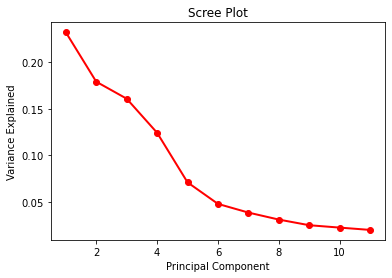

In [44]:


PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

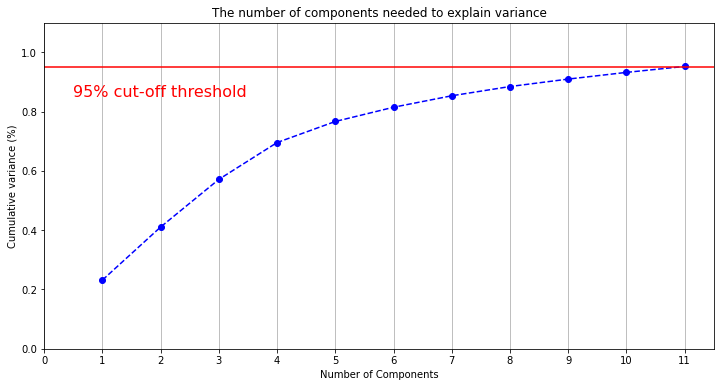

In [51]:
# matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 12, step=1)
yp = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yp, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 12, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [55]:
X_pc = pca.transform(X)

In [60]:
pca_col =list()

for i in np.arange(1,12,1):
    pca_col.append("PC_{}".format(i))
 

['PC_1',
 'PC_2',
 'PC_3',
 'PC_4',
 'PC_5',
 'PC_6',
 'PC_7',
 'PC_8',
 'PC_9',
 'PC_10',
 'PC_11']

In [62]:

X_pc = pd.DataFrame(X_pc, columns =pca_col )

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df4['isFraud'] == target
    ax.scatter(X_pc.loc[indicesToKeep, 'PC_1']
               , X_pc.loc[indicesToKeep, 'PC_2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [67]:
X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(X_pc, y, test_size=0.3, random_state=1, stratify=y)

In [70]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train_pc, y_train_pc)

print(f'''Shape of X before SMOTE: {X_train_pc.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
pd.DataFrame(y_sm).value_counts(normalize=True) * 100

Shape of X before SMOTE: (413353, 11)
Shape of X after SMOTE: (797778, 11)

Balance of positive and negative classes (%):


0.0    50.0
1.0    50.0
dtype: float64

In [71]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train_pc, y_train_pc)

In [72]:
print(f'''Shape of X before SMOTE: {X_train_pc.shape}
Shape of X after SMOTE: {X_resampled.shape}''')

print('\nBalance of positive and negative classes (%):')
pd.DataFrame(y_resampled).value_counts(normalize=True) * 100

Shape of X before SMOTE: (413353, 11)
Shape of X after SMOTE: (797778, 11)

Balance of positive and negative classes (%):


0.0    50.0
1.0    50.0
dtype: float64

In [75]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(max_depth= 31, n_estimators = 96)
rf2.fit(X_sm,y_sm)

RandomForestClassifier(max_depth=31, n_estimators=96)

In [76]:
y_pred_rf2 = rf2.predict(X_test_pc)

In [77]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(accuracy_score(y_test_pc, y_pred_rf2))



print(classification_report(y_test_pc, y_pred_rf2))

0.5261696170520231
              precision    recall  f1-score   support

         0.0       0.97      0.52      0.68    170953
         1.0       0.04      0.59      0.08      6199

    accuracy                           0.53    177152
   macro avg       0.51      0.56      0.38    177152
weighted avg       0.94      0.53      0.66    177152



In [79]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pc, y_pred_rf2)

array([[89548, 81405],
       [ 2535,  3664]])

In [80]:
rf2.fit(X_train_pc,y_train_pc)

RandomForestClassifier(max_depth=31, n_estimators=96)

In [81]:
y_pred_rf3 = rf2.predict(X_test_pc)

In [82]:
confusion_matrix(y_test_pc, y_pred_rf3)

array([[170624,    329],
       [  6132,     67]])

 Use PCA after oversampling

In [84]:
sm = SMOTE(r+andom_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)


In [85]:
from sklearn.decomposition import PCA
#define PCA model to use
pca = PCA(n_components = 0.95).fit(X_sm)

In [86]:
X_train_pc = pca.transform(X_sm)
X_test_pc = pca.transform(X_test)

In [87]:
pca_col =list()
for i in np.arange(1,pca.n_components_+1,1):
    pca_col.append("PC_{}".format(i))
X_train_pc = pd.DataFrame(X_train_pc, columns =pca_col )
X_test_pc = pd.DataFrame(X_test_pc, columns =pca_col )

In [88]:
rf2.fit(X_train_pc,y_sm)

RandomForestClassifier(max_depth=31, n_estimators=96)

In [89]:
y_pred_rf4 = rf2.predict(X_test_pc)

In [90]:
confusion_matrix(y_test, y_pred_rf4)

array([[86908, 84045],
       [ 2350,  3849]])

In [93]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state = 42)
X_smt, y_smt = smt.fit_resample(X_train, y_train)


KeyboardInterrupt: 

In [109]:
X1, X_try, y1, y_try = train_test_split(X_train, y_train, test_size=0.3, random_state=1, stratify=y_train)

In [110]:
X_try.shape

(124006, 599)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state = 42)
X_smt1, y_smt1 = smt.fit_resample(X1, y1)

In [100]:
rf2.fit(X_smt1,y_smt1)

RandomForestClassifier(max_depth=31, n_estimators=96)

In [101]:
y_pred_rf5 = rf2.predict(X_try)

In [102]:
confusion_matrix(y1, y_pred_rf5)

array([[350331,  38586],
       [  8712,   5390]])

In [103]:
print(accuracy_score(y1, y_pred_rf5))



print(classification_report(y1, y_pred_rf5))

0.8826407687975009
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94    388917
         1.0       0.12      0.38      0.19     14102

    accuracy                           0.88    403019
   macro avg       0.55      0.64      0.56    403019
weighted avg       0.95      0.88      0.91    403019



In [104]:
X_sm2, y_sm2 = sm.fit_resample(X_try, y_try)

In [105]:
rf2.fit(X_sm2,y_sm2)

RandomForestClassifier(max_depth=31, n_estimators=96)

In [106]:
y_pred_rf6 = rf2.predict(X1)

In [107]:
confusion_matrix(y1, y_pred_rf6)

array([[348217,  40700],
       [  8624,   5478]])

In [108]:
print(accuracy_score(y1, y_pred_rf6))



print(classification_report(y1, y_pred_rf6))

0.8776137105198514
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.93    388917
         1.0       0.12      0.39      0.18     14102

    accuracy                           0.88    403019
   macro avg       0.55      0.64      0.56    403019
weighted avg       0.95      0.88      0.91    403019

